<a href="https://colab.research.google.com/github/VAASUsr/Srividhya/blob/main/second_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving sales1.csv to sales1.csv


In [ ]:
# Run this cell in colab (installs only if needed)
!pip install -q scikit-learn pandas matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [ ]:
# if using colab, upolad file to files or mount Drive, e.g.:
# from google.colab import drive
# drive.mount('/content/drive')
# path = '/content/drive/mydrive/sales1.csv'



path = 'sales1.csv'
df = pd.read_csv("sales1.csv", parse_dates=["date"])
df = df.sort_values('date').reset_index(drop=True)
display(df.head())

,date,sales
0,2023-01-01,202
1,2023-01-02,535
2,2023-01-03,960
3,2023-01-04,370
4,2023-01-05,206


In [ ]:
# Basic checks

print(df.info())
print(df.describe())

# Example: creat monthly/year and lag features (optional but helps forecasting)
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year


#Create 1-month lag of sales and 3-month rolling mean (only for regression-with-lags)
df['sales1_lag_1'] = df['sales'].shift(1)
df['sales1_roll3'] = df['sales'].rolling(window=3).mean().shift(1)

# Drop initial rows with NaNs created by lags
df_model = df.dropna().reset_index(drop=True)
display(df_model.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    100 non-null    datetime64[ns]
 1   sales   100 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.7 KB
None
                      date       sales
count                  100  100.000000
mean   2023-02-19 12:00:00  538.400000
min    2023-01-01 00:00:00  101.000000
25%    2023-01-25 18:00:00  311.750000
50%    2023-02-19 12:00:00  531.000000
75%    2023-03-16 06:00:00  767.500000
max    2023-04-10 00:00:00  997.000000
std                    NaN  264.368239


,date,sales,month,year,sales1_lag_1,sales1_roll3
0,2023-01-04,370,1,2023,960.0,565.666667
1,2023-01-05,206,1,2023,370.0,621.666667
2,2023-01-06,171,1,2023,206.0,512.000000
3,2023-01-07,800,1,2023,171.0,249.000000
4,2023-01-08,120,1,2023,800.0,392.333333


In [ ]:
# choose features (simple)
features = ['month', 'year', 'sales1_lag_1', 'sales1_roll3']
x = df_model[features]
y = df_model['sales']

from sklearn.metrics import mean_absolute_error

# train/test split (time-ordered split is best, bit this is simplest)
# for time-series keep the temparal order: use the last N rows as test
test_size = int(0.2 * len(df_model))
x_train, x_test = x.iloc[:-test_size], x.iloc[-test_size:]
y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

#metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test,y_pred)
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse, "MAE:", mae, "R2:", r2)

RMSE: 269.72976751891287 MAE: 233.75426968561553 R2: 0.008937319332896765


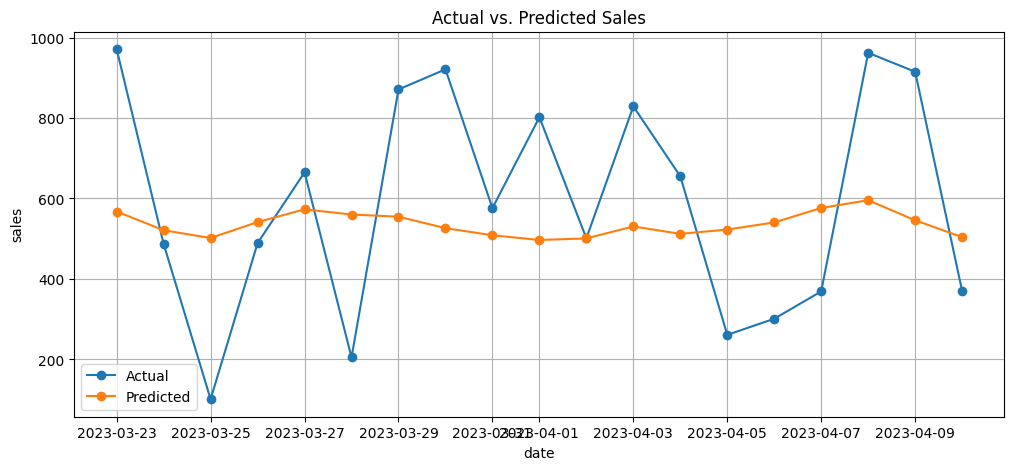

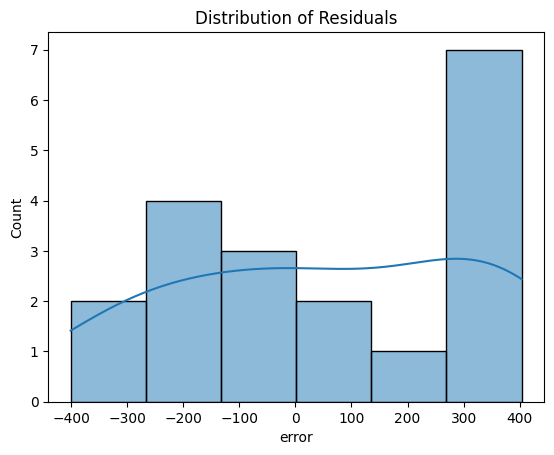

In [ ]:
# put results into a dataframe for plotting
res = x_test.copy()
res['date'] = df_model['date'].iloc[-test_size:].sort_values().values # Corrected column name and sorting assignment
res['actual'] = y_test
res['predicted'] = y_pred

# plot
plt.figure(figsize=(12, 5))
plt.plot(res['date'], res['actual'], label='Actual', marker='o') # Corrected variable name
plt.plot(res['date'], res['predicted'], label='Predicted', marker='o')
plt.xlabel('date'); plt.ylabel('sales')
plt.title('Actual vs. Predicted Sales')
plt.legend();plt.grid(True)
plt.show()


# plot residuals
res['error'] = res['actual'] - res['predicted']
sns.histplot(res['error'], kde=True)
plt.title('Distribution of Residuals');plt.show()

In [ ]:
out = res[['date', 'actual', 'predicted']].copy()
out.to_csv('predictions.csv', index=False)
print("saved predictions.csv")

saved predictions.csv


In [ ]:
future_steps = 6
last_row = df_model.iloc[-1].copy()
future_rows =[]
new = last_row.copy()
#set data forward (monthly)
new['data'] = new['date'] + pd.DateOffset(months=1)
# set ad_budget/price/discount for new period (you choose logic)
# set lag features using last_row.sales or predictions
new['sales1_lag_1'] = last_row['sales'] # or predicted value
new['sales1_roll3'] = df['sales'].iloc[-3:].mean() # simple
x_new = new[features].values.reshape(1, -1)
y_new = model.predict(x_new)[0]
new['sales'] = y_new
future_rows.append(new)
last_row = new
future_df = pd.DataFrame(future_rows)
future_df[['data','sales']].head()

# repeat for future steps

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


,data,sales
96,2023-05-10,505.797406
